In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import shap

/home/edvinas/miniconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import data prepared in previous steps (only data for 2018 survey, full time employment, and removed outliers) and used for all machine learning models. The target is hourly rate and predictors are economic sector (nace), company size (esize_class), gender, age class, profession (lpk), education. All these are categorical variables. Single numerical variable is experience in years.

In [3]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv') 
data.head()

,nace,esize_class,gender,age_class,lpk,education,experience,target
0,C,1_49,M,40-49,p721,G2,13,8.20
1,C,1_49,F,40-49,p334,G2,0,2.51
2,M,50_249,F,40-49,p522,G2,18,2.19
3,M,50_249,F,40-49,p522,G2,12,2.19
4,M,50_249,F,14-29,p522,G2,0,2.19


One fifth of records is kept for testing of models.

In [4]:
y = data['target']
X = data.drop(columns='target')

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)

print('Dataset lengths:', 'train', len(y_train), ', test', len(y_test))

Dataset lengths: train 26114 , test 6529


# Model and predictions

## Initial model

Initial XGB model used to test pipline and estimate the baseline accuracy. Numerical feature is scaled with [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and categorical features are encoded using [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) with automatically determined categories.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from xgboost import XGBRegressor

numeric_preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

categorical_preprocessor = Pipeline(steps=[("ordinal", OrdinalEncoder())])

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, ['nace', 'esize_class', 'gender', 'age_class', 'lpk', 'education']),
        ("numerical", numeric_preprocessor, ['experience'])
    ]
)

model = Pipeline([('prep', preprocessor), ('regr', XGBRegressor())])
model.fit(X=X_train, y=y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['nace', 'esize_class',
                                                   'gender', 'age_class', 'lpk',
                                                   'education']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['experience'])])),
                ('regr',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, col...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

Function to print model prediction RMSE and R2

In [6]:
def print_model_rmse_r2(model, X_train, y_train, X_test, y_test):
    """ 
    Function to print model prediction RMSE and R2
    for train and test datasets
        Parameters:
        model - model to evaluate
        X_train - train features
        y_train - train target 
        X_test - test features
        y_test - test target
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3)

    r2_train = r2_score(y_train, y_train_pred).round(3)
    r2_test = r2_score(y_test, y_test_pred).round(3)

    print('Train: RMSE=', rmse_train, ' R2=', r2_train,
        '\nTest: RMSE=', rmse_test, ' R2=', r2_test)

RMSE and R2 of initial model predicions for train and test datasets

In [7]:
print_model_rmse_r2(model, X_train, y_train, X_test, y_test)

Train: RMSE= 1.342  R2= 0.722 
Test: RMSE= 1.629  R2= 0.589


## Randomized Search CV

Randomized cross validation was used to tune model. Randomized search used to quickly explore parameter space and test if tuning of hyperparameters potentially can provide substantial gains over initial model.

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
model = Pipeline([('prep', preprocessor), ('regr', XGBRegressor())])

grid = {'regr__max_depth':np.arange(5, 15, dtype=int),
        'regr__eta': np.linspace(0.05, 0.55, 9),
        'regr__gamma': np.linspace(1,  3,  9),
        'regr__min_child_weight': np.arange(1, 6, dtype=int),
        'regr__subsample': np.linspace(0.3, 1, 9), 
        'regr__colsample_bytree': np.linspace(0.3,  1,  9),
        'regr__alpha': np.linspace(0,  1,  9),
        'regr__lambda' : [1, 5, 10, 20],
        'regr__learning_rate': np.linspace(0.05,  0.2,  4)
         }
search = RandomizedSearchCV(model, grid, scoring='neg_root_mean_squared_error', n_iter = 150, cv=cv, n_jobs=-1)
results = search.fit(X=X_train,y=y_train)

results_pd = pd.DataFrame(results.cv_results_)
results_pd.filter(regex='rank|regr|mean_test_score|std_test_score',axis=1).sort_values('rank_test_score').head().T

,123,39,125,62,70
param_regr__subsample,1.0,0.825,1.0,0.9125,0.5625
param_regr__min_child_weight,4,3,2,4,5
param_regr__max_depth,12,10,12,12,12
param_regr__learning_rate,0.05,0.05,0.05,0.1,0.05
param_regr__lambda,1,5,5,20,1
param_regr__gamma,3.0,2.0,2.25,1.25,1.25
param_regr__eta,0.3625,0.3,0.3625,0.3,0.2375
param_regr__colsample_bytree,0.65,0.9125,0.825,0.65,0.7375
param_regr__alpha,0.75,0.25,1.0,1.0,0.75
mean_test_score,-1.644908,-1.649412,-1.649567,-1.649735,-1.650393


In [9]:
best_model=results.best_estimator_
best_model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['nace', 'esize_class',
                                                   'gender', 'age_class', 'lpk',
                                                   'education']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['experience'])])),
                ('regr',
                 XGBRegressor(alpha=0.75, base_score=0.5, booster='gbtree',
                              callbacks=None, colsample_by...
                              enable_categorical=False, eta=0.3625,
                              eval_metric=None, feature_types=None, gamma=3.0,
                              gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              lambda=1, learning_rate=0.05, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=12, max_leaves=0,
                              min_child_weight=4, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, ...))])

In [10]:
print_model_rmse_r2(best_model, X_train, y_train, X_test, y_test)

Train: RMSE= 1.374  R2= 0.709 
Test: RMSE= 1.598  R2= 0.604


Variability of parameter values is significant for five best iterations and performance gain over untuned initial model is marginal. Small changes of scores suggest that the loss gradient is small near best iterations. The model with parameters from best iteration will be used for further analysis.

## Feature importance

We tested the feature importance using native XGBoost, permutation and [SHAP](https://shap.readthedocs.io/en/latest/) feature importance methods.

### XGBoost

In [11]:
best_regr = best_model.named_steps["regr"]
feature_importances = best_regr.feature_importances_

prep = best_model.named_steps["prep"]
feature_names = prep.get_feature_names_out()

importances = pd.DataFrame({'importance': feature_importances }, index=feature_names )
importances.sort_values('importance', ascending=False)

,importance
categorical__lpk,0.294869
categorical__education,0.272259
categorical__esize_class,0.204879
categorical__gender,0.102770
categorical__nace,0.053470
categorical__age_class,0.039272
numerical__experience,0.032481


### SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


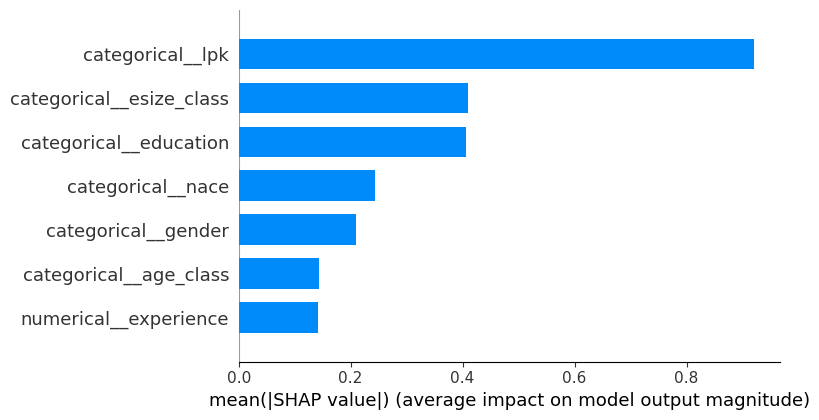

In [12]:
explainer = shap.TreeExplainer(best_regr, feature_names=feature_names)
shap_values = explainer(prep.transform(X_test))
shap.summary_plot(shap_values, plot_type="bar");

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


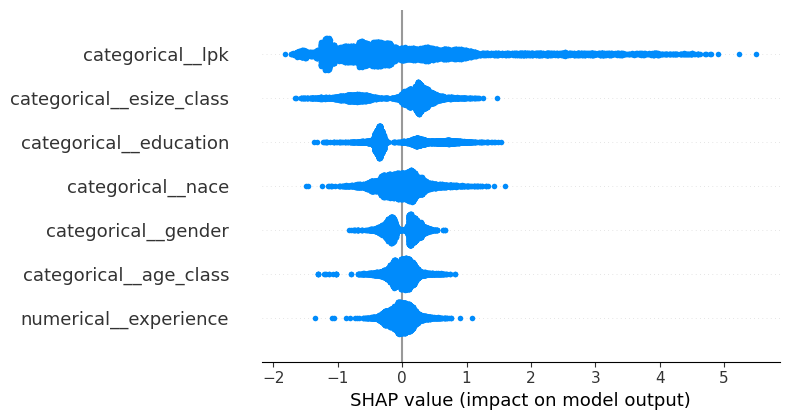

In [13]:
shap_values = shap.TreeExplainer(best_model['regr']).shap_values(prep.transform(X_test))
shap.summary_plot(shap_values, feature_names=feature_names );

## Permutation importance

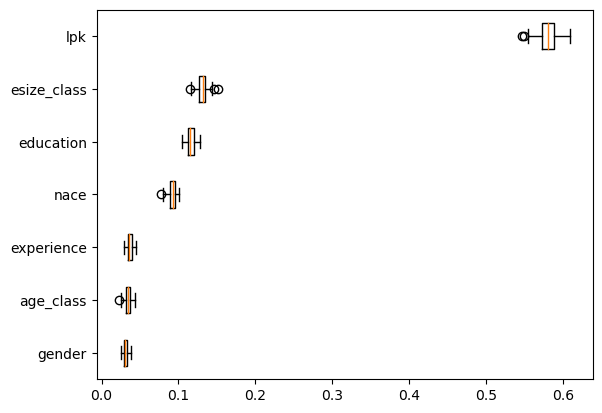

In [14]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_model, X_test, y_test,  n_repeats=100,  random_state=0)
importance_order = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots()
plt.boxplot(
    perm_importance.importances[importance_order].T,
    vert=False,
    labels=np.array(X_test.columns)[importance_order],
);

By far the most important feature is profession (lpk) followed by company size and education. The economic sector, experience, age and gender are less important. Feature immportance results might be affected by large cardinality of lpk and nace.

# Model (Pipline) Serialization 

In [16]:
import joblib
joblib.dump(best_model, './Models/XGBoost_model.joblib')

['./Models/XGBoost_model.joblib']